In [6]:
import os
import nvgpu


avail_gpu = nvgpu.available_gpus()[0]

os.environ['NVIDIA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [7]:
!pip install nvgpu

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGPooling,GlobalAttention,global_add_pool,SAGEConv,ChebConv,GraphConv,graclus, global_mean_pool
import numpy as np
from torch_geometric import data 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torch.nn.init

In [9]:
device = torch.device( "cuda")

## Loading histo data

In [10]:
import pandas as pd
histo_data = pd.read_csv('/isilon/projects/entire-gdc-validation/gdc_data.csv')
histo_data['file_type'] = histo_data.file_name.apply(lambda x: x.split('-')[5][:2])
histo_data['section_type'] = histo_data.file_type.apply(lambda x: {
    'DX': 'Biopsy', 'TS': 'Frozen', 'BS': 'Frozen', 'MS': 'Unknown'}[x])
histo_data['health_type'] = histo_data.sample_type.apply(lambda x: 'Healthy' if x == 'Solid Tissue Normal' else 'Unhealthy')

In [11]:
#lung_data = data[(data.primary_site == 'Lung') & (data.section_type == 'Biopsy')]
#lung_data = data[data.primary_site == 'Lung']
histo_data = histo_data[(histo_data.health_type == 'Unhealthy') & 
                        (histo_data.primary_site == 'Lung') & 
                        (histo_data.section_type == 'Biopsy') ]

In [ ]:
import json
import requests
import pandas as pd
import io

def get_associated_cases():
    fields = [
        "cases.project.primary_site",
        "cases.case_id",
        "cases.submitter_id",
        "cases.project.disease_type",
        "cases.samples.pathology_report_uuid",
        "cases.samples.sample_type",
        "cases.diagnoses.primary_diagnosis",
        "cases.diagnoses.morphology",
        "file_id",
        "file_name",
        "md5sum",
        "file_size"
    ]
    
    fields = ",".join(fields)
    
    file_endpt = "https://api.gdc.cancer.gov/files/"
    
    filters = {
       "op": "=",
       "content":{
            "field": "files.data_type",
            "value": "Slide Image"
       }
    }

    # A POST is used, so the filter parameters can be passed directly as a Dict object.
    params = {
       "filters": json.dumps(filters),
       "fields": fields,
       "format": "CSV",
       "size": "1000000"
       }
    response = requests.get(file_endpt,params = params)
    return pd.read_csv(io.StringIO(response.content.decode("utf-8")))

all_cases = get_associated_cases()
filtered_cases = all_cases[[ 'file_name', "file_id", "md5sum", "file_size", 
                            'cases.0.case_id', 'cases.0.submitter_id', 'cases.0.samples.0.sample_type', 
                            'cases.0.project.primary_site', 
                            'cases.0.project.disease_type', 'cases.0.diagnoses.0.morphology', 
                            'cases.0.samples.0.pathology_report_uuid', 'cases.0.diagnoses.0.primary_diagnosis']]
filtered_cases.columns = ['file_name', 'file_id', "md5sum", "file_size", 'case_id', 'submitter_id', 'sample_type', 'primary_site', 
                          'primary_diagnosis', 'morpholoy', 'pathology_report_uuid', 'primary_diagnosis_subtype']
filtered_cases['file_type'] = filtered_cases.file_name.apply(lambda x: x.split('-')[5][:2])
filtered_cases['section_type'] = filtered_cases.file_type.apply(lambda x: {'TS':'Frozen', 
                                                                           'BS': 'Frozen', 
                                                                           'DX': 'Biopsy', 
                                                                           'MS': 'Unknown' }[x])

In [ ]:
histo_data = filtered_cases[['file_name', 'case_id']].merge(histo_data, on='file_name').reset_index(drop=True)

In [ ]:
import numpy as np
pd_dict = {pd: i for i, pd in enumerate(histo_data.primary_diagnosis.unique())}
one_hot_encoder = np.eye(len(histo_data.primary_diagnosis.unique()))

In [ ]:
import numpy as np
def read_barcodes(file_path):
    with open(file_path, 'r') as f:
        barcodes = f.read().split('\n')
        arr = np.array([list(map(int, barcode.strip().split(' '))) 
                        for barcode in barcodes if barcode.strip()])
        arr = arr.astype('uint8')
    return np.unpackbits(arr, axis=-1)

def read_features(file_path):
    with open(file_path.replace('_barcode', '_feature'), 'r') as f:
        features = f.read().split('\n')
        arr = np.array([list(map(float, feature.strip().split(' '))) 
                        for feature in features if feature.strip()])
    
    return arr

features = [read_features(b_file) for b_file in histo_data.barcode_file]

In [ ]:
max_n = max([feat.shape[0] for feat in features])

In [ ]:
padded_features = np.zeros( (len(features), max_n, features[0].shape[1]) )

for i, feat in enumerate(features):
    padded_features[i, :len(feat), :] = feat

In [ ]:
labels = [one_hot_encoder[pd_dict[diagnosis]] for diagnosis in histo_data.primary_diagnosis]

In [ ]:
y = np.array(labels)[:, 0]

## Train-Test split

In [ ]:
idxs = np.arange(0, len(y))
np.random.shuffle(idxs)

cut_idx = int(0.3*len(y))
test_idx = idxs[:cut_idx]
train_idx = idxs[cut_idx:]

train_features = padded_features[train_idx]
train_labels = y[train_idx]

test_features = padded_features[test_idx]
test_labels = y[test_idx]

In [ ]:
np.save('data/train_x', train_features)
np.save('data/train_y', train_labels)
np.save('data/test_x', test_features)
np.save('data/test_y', test_labels)

## Loading data to CUDA

In [ ]:
x_train=torch.from_numpy(train_features)
y_train=torch.from_numpy(train_labels)

x_test=torch.from_numpy(test_features)
y_test=torch.from_numpy(test_labels)

x_train=x_train.to(device)
y_train=y_train.to(device)

In [ ]:
class fe_extrator(nn.Module):

    def __init__(self):
        super(fe_extrator, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.fc1=nn.Linear(1024, 784)
        self.fc2=nn.Linear(784, 512)
        self.fc3=nn.Linear(512, 512)
        #self.fc3=nn.Linear(256, 128)
        self.d=nn.Dropout(0.5)

    def forward(self,x):
        
        mask = (x.sum(-1) != 0).type(torch.DoubleTensor)
        mask = mask.unsqueeze(-1).to(device)
        
        x=self.fc1(x)
        x=self.d(x)
        x= F.relu(x)
        x = x * mask
        
        x=self.fc2(x)
        x=self.d(x)
        x= F.relu(x)
        x = x * mask
                
        x=self.fc3(x)
        x=self.d(x)
        x= F.relu(x)
        x = x * mask
        
        return x

In [ ]:
class c_vector(nn.Module):
    
    def __init__(self):
        
        super(c_vector,self).__init__()
        self.fc1=nn.Linear(512, 128)
    
    def forward(self,x):
        num_el = (x.sum(-1) != 0).type(torch.DoubleTensor).sum(1)
        #print(num_el)
        x=x.sum(1)/num_el.unsqueeze(-1).to(device)
        x=self.fc1(x)
        x=F.relu(x)
        return x
        

class adj(nn.Module):
    
    def __init__(self):
        
        super(adj,self).__init__()
        
        self.fc1=nn.Linear(512+128, 512)
        self.fc2=nn.Linear(512, 384)
        
        
    def forward(self,x):
        
        mask = (x[:, :, :512].sum(-1) != 0).type(torch.DoubleTensor)
        mask = mask.unsqueeze(-1).to(device)
        
        x=self.fc1(x)
        x = x * mask
        x=F.relu(x)
        
        x=self.fc2(x)
        x = x * mask
        x=F.relu(x)
        
        x=torch.bmm(x,torch.transpose(x,1,2))
        # ff
        #x=F.tanh(x)
        
        return x

att_net=nn.Sequential(nn.Linear(384, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 1), nn.Tanh() )
pool=GlobalAttention(att_net)


class gnet(torch.nn.Module):
    
    def __init__(self):
        super(gnet, self).__init__()
        self.conv1 = ChebConv(512, 512, 5)
        self.conv2 =  ChebConv(512, 384, 5)
        #self.conv3 =  ChebConv(256, 256, 10)
        #self.conv1 = SAGEConv(512, 512)
        #self.conv2 =  SAGEConv(512, 384)
        
        
    def forward(self, dat):
        x, edge_index, edge_weight, batch= dat.x, dat.edge_index, dat.edge_attr,dat.batch
        
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index=edge_index, edge_weight=edge_weight)
        x=F.relu(x)
        
        #x = self.conv3(x, edge_index=edge_index,edge_weight=edge_weight)
        #x=F.relu(x)
        
        x=x.type(torch.FloatTensor)
        x=pool(x, batch)
        #print(batch)
        
        #x = global_mean_pool(x, batch)
        #x=global_add_pool(x,batch)
        #x=F.tanh(x)

        return x, x1

    
class mlp(nn.Module):
    
    def __init__(self):
        super(mlp, self).__init__()   
        self.fc1=nn.Linear(384, 256)
        #self.fc2=nn.Linear(256, 128)
        #self.fc3=nn.Linear(128, 64)
        self.fc4=nn.Linear(256, 1)
        
    
    def forward(self,x):
        x=self.fc1(x)
        #x=nn.Dropout(x)
        x=F.relu(x)
        
        #x=self.fc2(x)
        #x=F.relu(x)
        
        #x=self.fc3(x)
        #x=F.relu(x)
        
        x=self.fc4(x)
        x=torch.sigmoid(x)
        return x


class final_model(nn.Module):
    
    def __init__(self):
        
        super(final_model,self).__init__()
        self.fea_model=fe_extrator().cuda()
        self.c_net=c_vector().to(device)
        self.adj_mat=adj().to(device)
        self.graphcnn=gnet().to(device)
        self.mlp_out=mlp().to(device)
        
    def forward(self, inp, y):
        inp=inp.to(device)
        #x, edge_index, edge_weight,batch = data.x, data.edge_index,data.weight,data.batch
        inp=inp.type(torch.DoubleTensor) ####CHECK
        
        fea_o=self.fea_model(inp.cuda())      ##### features for gcnn
        
        c=self.c_net(fea_o)
        
        q=[torch.cat((fea_o[:,i,:],c),1) for i in range(inp.shape[1])]
        q=torch.stack(q)
        q=q.permute(1,0,2)
        adj_matrix=self.adj_mat(q)    #### adjance matrix
        
        # no of edges n(n-1)
        n_edges=inp.shape[1]*(inp.shape[1]-1) + inp.shape[1]
        edge_index=[]
        
        num_els = (fea_o.sum(-1) != 0).type(torch.DoubleTensor).sum(axis=1)
        num_els = num_els.cpu().detach().numpy().astype('int')
        
        for n, nel in zip(range(inp.shape[0]), num_els):
            temp_index = np.ones((2, int(nel**2) ))
            count_row=0
            count_col=0
            for i in range( int(nel) ):
                node_list=list(np.arange( int(nel) ))
                #node_list.remove(i)
                #node_list=np.array(node_list)

                for j in node_list:

                    temp_index[0,count_row]=i
                    temp_index[1,count_col]=j
                    
                    count_col = count_col+1
                    count_row = count_row+1
                                 
            edge_index.append(temp_index)
                
        edge_attr=[]
        
        adj_matrix=adj_matrix.cpu()
        
                                 
        for n, nel in zip(range(inp.shape[0]), num_els):
            temp_attr = np.zeros(( int(nel**2), 1))
            for i in range(nel**2):
                row=edge_index[n][0,i]
                col=edge_index[n][1,i]
                
                temp_attr[i,:]=adj_matrix.data[n,int(row),int(col)]
                
            edge_attr.append(temp_attr)
        
        
        dat=[]
        
        
        for n, nel in zip(range(inp.shape[0]), num_els):

            _edge_attr = edge_attr[n]
            
            _edge_attr=torch.from_numpy(_edge_attr).double()  #CHECK
            #edge_attr=torch.tensor(edge_attr,device=device)
            _edge_attr=_edge_attr.view(_edge_attr.shape[0])


            _edge_index = edge_index[n]
            _edge_index=torch.from_numpy(_edge_index)
            #edge_index=edge_index.type(torch.LongTensor).cuda()

            _edge_attr=_edge_attr.type(torch.DoubleTensor)
            _edge_attr=_edge_attr.cuda()

            temp=data.Data(x=fea_o[n,:nel,:].view(nel, fea_o.shape[2]),
                           edge_index=_edge_index.type(torch.LongTensor).cuda(), edge_attr=_edge_attr,y=y[n].view(1))
            dat.append(temp)

        dat=data.DataLoader(dat, batch_size=inp.shape[0])
                
        for g_batch in dat:      
            #print(g_batch.edge_attr)
            #print('I did')
            x,x1=self.graphcnn(g_batch)
            y_batch=g_batch.y
        
        x=x.type(torch.DoubleTensor).cuda()
        bf_x = x
        x=self.mlp_out(x)
        
        #print(y)
        return x, y_batch, adj_matrix, bf_x


def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
#        torch.nn.init.xavier_uniform(m.bias.data)



In [ ]:
#data loader
class HistoDataset(Dataset):
    
    def __init__(self, x,y, transform=None):
        self.x = x
        self.y=y
        
    def __len__(self):
        return (self.x.shape[0])
    
    def __getitem__(self, index):
        x_train = self.x[index,:,:]
        label = self.y[index]
        return x_train,label

In [ ]:
def acc(x_test,y_test):

    my_model.eval()
    a,b, _, _ =my_model(x_test,y_test)
    a=a.cpu().detach().numpy()
    b=b.cpu().detach().numpy()

    a=np.round(a)
    a.reshape(x_test.shape[0])
    y_tes=y_test.cpu().detach().numpy()
    
    count=0
    for i in range(x_test.shape[0]):

        if b[i]==a[i]:
            count=count+1
                
    return count/x_test.shape[0]

In [ ]:
patient_ids = histo_data.sample(frac=1).case_id.dropna().unique()

cut_idx = int(patient_ids.shape[0]*0.7)
train_patient_ids = set(patient_ids[:cut_idx])
test_patient_ids = set(patient_ids[cut_idx:])

In [ ]:
from sklearn.model_selection import KFold 
fold_accuracies=[]
! touch print.txt
kf = KFold(n_splits=5,shuffle=True,random_state=98)

fl = open('./print-sk.txt', 'w')
for train_index, test_index in kf.split(patient_ids):
    
    train_patient_ids = set(patient_ids[train_index])
    test_patient_ids = set(patient_ids[test_index])
    
    
    train_histo_data = histo_data[histo_data.case_id.apply(lambda x: x in train_patient_ids)]
    test_histo_data = histo_data[histo_data.case_id.apply(lambda x: x in test_patient_ids)]
    
    _train_index = train_histo_data.index.tolist()
    _test_index = test_histo_data.index.tolist()
    
    x_train, x_test = padded_features[_train_index], padded_features[_test_index]
    y_train, y_test = y[_train_index], y[_test_index]

    x_train=torch.from_numpy(x_train)
    y_train=torch.from_numpy(y_train)

    x_test=torch.from_numpy(x_test)
    y_test=torch.from_numpy(y_test)

    train_dataset=HistoDataset(x_train, y_train)
    train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True)
    train_iter = iter(train_loader)

    my_model=final_model()
    my_model.double()
    my_model=my_model.to(device)
    my_model.apply(weights_init)
    criterion=nn.BCELoss()
    optimizer=optim.Adam(my_model.parameters(), lr=7e-4,weight_decay=1e-4)

    # run epochs per fold
    epochs=75
    accuracy=[]
    my_model.train()

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        train_iter = iter(train_loader)
        count=0
        for i, train_data in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, y_label = train_data

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs, labels, _, _ = my_model(inputs, y_label)

            #print(y_label)
            #print(outputs)

            #print(fe)
            #print(adj)
            outputs=outputs.view(outputs.shape[0])
            loss = criterion(outputs.to(device), labels.type(torch.DoubleTensor).to(device))
            loss.backward()
            optimizer.step()

            count=count+1
            #print(loss)
            # print statistics
            running_loss += loss.item()
        temp= acc(x_test, y_test)
        accuracy.append(temp)
        print('epoch',epoch, 'loss:',running_loss/count, 'accuracy on test,train=',temp)
        print('epoch',epoch, 'loss:',running_loss/count, 'accuracy on test,train=',temp, file=fl, flush=True)

        
    del my_model, x_train, x_test, y_train, y_test
    fold_accuracies.append(accuracy)

In [25]:
train_histo_data = histo_data[histo_data.case_id.apply(lambda x: x in train_patient_ids)]
test_histo_data = histo_data[histo_data.case_id.apply(lambda x: x in test_patient_ids)]

_train_index = train_histo_data.index.tolist()
_test_index = test_histo_data.index.tolist()

x_train, x_test = padded_features[_train_index], padded_features[_test_index]
y_train, y_test = y[_train_index], y[_test_index]

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)


train_dataset=HistoDataset(x_train, y_train)
train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True)
train_iter = iter(train_loader)

In [1]:
my_model=final_model()
my_model.double()
my_model=my_model.to(device)
my_model.apply(weights_init)
criterion=nn.BCELoss()
optimizer=optim.Adam(my_model.parameters(), lr=7e-4,weight_decay=1e-4)

# run epochs per fold
epochs=75
accuracy=[]
my_model.train()

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    train_iter = iter(train_loader)
    count=0
    for i, train_data in enumerate(train_loader):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, y_label = train_data

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs, labels, _, _ = my_model(inputs.cuda(), y_label.cuda())

        #print(y_label)
        #print(outputs)

        #print(fe)
        #print(adj)
        outputs=outputs.view(outputs.shape[0])
        loss = criterion(outputs.to(device), labels.type(torch.DoubleTensor).to(device))
        loss.backward()
        optimizer.step()

        count=count+1
        #print(loss)
        # print statistics
        running_loss += loss.item()
    temp= acc(x_test, y_test)
    accuracy.append(temp)
    print('epoch',epoch, 'loss:',running_loss/count, 'accuracy on test,train=',temp)

NameError: name 'final_model' is not defined

In [27]:
my_model.eval()
_, _, _, feats = my_model(x_test, y_test)

In [32]:
from sklearn.manifold import TSNE

In [53]:
y_test

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 1., 

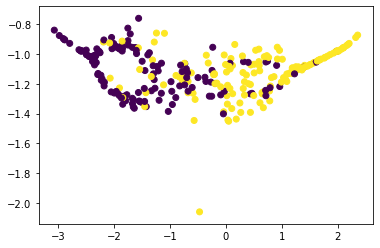

In [60]:
tsne = TSNE(perplexity=200)
tsne_data = tsne.fit_transform(feats.cpu().detach().numpy())

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c= y_test)

In [73]:
att_net(feats[0].type(torch.FloatTensor).cpu())

tensor([-0.1207], grad_fn=<TanhBackward>)

In [72]:
feats.shape

torch.Size([285, 384])